In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Clean the data

In [22]:
la_crime = "la_crime_2020_2024_reduced_2.csv"
crime_df = pd.read_csv(la_crime)

la_weather = "la_weather_2020_2024_cleaned.csv"
weather_df = pd.read_csv(la_weather)

# Columns to drop
drop_cols = ["DR_NO",
             "Crm Cd 1", "Crm Cd 2", "Crm Cd 3", "Crm Cd 4", "Weapon Desc", 
             "LOCATION"]
crime_df = crime_df.drop(drop_cols, axis=1)

# Rename the columns accordingly
cols_rename = {
    "Date Rptd":"DATE_REPORTED",
    "DATE OCC":"DATE_OCCURRED",
    "TIME OCC":"TIME_OCCURRED",
    "AREA NAME":"AREA_NAME",
    "Crm Cd Desc":"CRIME_DESCRIPTION",
    "Crm Cd": "CRIME_CODE",
    "Vict Age":"VICTIM_AGE",
    "Vict Sex":"VICTIM_SEX",
    "Vict Descent":"VICTIM_DESCENT",
    "Premis Desc":"PREMISE_DESCRIPTION",
    "Status Desc":"STATUS",
    "Category": "CRIME_CATEGORY"
}
crime_df = crime_df.rename(columns=cols_rename)

# Drop remaining rows with missing values
# 
crime_df["VICTIM_SEX"] = crime_df["VICTIM_SEX"].fillna("NAN")
crime_df["VICTIM_DESCENT"] = crime_df["VICTIM_DESCENT"].dropna()
# # Convert military format time to standard time object
# crime_df["TIME_OCCURRED"] = crime_df["TIME_OCCURRED"].astype(str).str.zfill(4)
# crime_df["TIME_OCCURRED"] = crime_df["TIME_OCCURRED"].str[:2] + ":" + crime_df["TIME_OCCURRED"].str[2:]
# crime_df["TIME_OCCURRED"] = pd.to_datetime(crime_df["TIME_OCCURRED"], format="%H:%M:%S")

# # Convert date columns to datetime objects
crime_df["DATE_OCCURRED"] = pd.to_datetime(crime_df["DATE_OCCURRED"], format="%m/%d/%Y %H:%M:%S %p")
crime_df["DATE_REPORTED"] = pd.to_datetime(crime_df["DATE_REPORTED"], format="%m/%d/%Y %H:%M:%S %p")
crime_df["TIME_OCCURRED"] = pd.to_datetime(crime_df["TIME_OCCURRED"], format="%H:%M:%S")

# Filter out rows with invalid geographical coordinates
crime_df = crime_df[(crime_df["LAT"] != 0) & (crime_df["LON"] != 0)]

# Filter out rows with invalid victim ages
crime_df = crime_df[crime_df["VICTIM_AGE"] > 0]

# Filter out rows after January 2024 
crime_df = crime_df[crime_df["DATE_OCCURRED"] < pd.to_datetime("2024-01-01")]

# Clean weather data
weather_df.rename(str.upper, axis="columns", inplace=True)
weather_df["DATETIME"] = pd.to_datetime(weather_df["DATETIME"])


### Feature Extraction


In [23]:

# Hour of the day
crime_df["HOUR"] = crime_df["TIME_OCCURRED"].dt.hour

# Month, Year
crime_df["YEAR_MONTH"] = crime_df["DATE_OCCURRED"].dt.to_period("M")

# Time to report
crime_df["TIME_TO_REPORT"] = crime_df["DATE_REPORTED"] - crime_df["DATE_OCCURRED"]

# Only Attempt
crime_df["ATTEMPT"] = crime_df["CRIME_DESCRIPTION"].str.contains("ATTEMPT")



# Format dates to be more readable
crime_df["DATE_OCCURRED"] = crime_df["DATE_OCCURRED"].dt.date
crime_df["DATE_REPORTED"] = crime_df["DATE_REPORTED"].dt.date
crime_df["TIME_OCCURRED"] = crime_df["TIME_OCCURRED"].dt.time

# # Crime Category
# crime_categories_inverse = {crime: category for category, crimes in crime_categories.items() for crime in crimes}
# crime_df["CRIME_CATEGORY"] = crime_df["CRIME_DESCRIPTION"].map(crime_categories_inverse)

# Join crime and weather data
crime_per_date = crime_df.groupby("DATE_OCCURRED").size().reset_index(name="CRIME_COUNT")

weather_df.rename(str.upper, axis="columns", inplace=True)
weather_df["DATETIME"] = pd.to_datetime(weather_df["DATETIME"]).dt.date

crime_weather_joined = pd.merge(crime_per_date, weather_df, how="inner", left_on="DATE_OCCURRED", right_on="DATETIME").drop("DATETIME", axis=1)
crime_weather_joined["DATE_OCCURRED"] = pd.to_datetime(crime_weather_joined["DATE_OCCURRED"])

crime_weather_joined["CRIME_COUNT"] = crime_weather_joined["CRIME_COUNT"].rolling(30).mean()
crime_weather_joined["TEMP"] = crime_weather_joined["TEMP"].rolling(30).mean()

### Discovering the Data

In [24]:
# Crime Category Proportions (top 5)
category_proportions = crime_df["CRIME_CATEGORY"].value_counts(normalize=True).head(5)

# How differently are men and women affected by different crime categories?
sex_per_category = crime_df.groupby("CRIME_CATEGORY")["VICTIM_SEX"].value_counts(normalize=True).unstack().apply(lambda x: x*100).filter(["M","F","X"], axis=1).sort_values(by="M", ascending=False)

# Average time to report per crime category
category_avg_ttr = crime_df.groupby("CRIME_CATEGORY")["TIME_TO_REPORT"].mean().dt.total_seconds().apply(lambda x: x/(60*60*24)).sort_values()

# Attempted crimes per category (top 5 attempted)
category_attempted = crime_df.groupby("CRIME_CATEGORY")["ATTEMPT"].value_counts(normalize=True).unstack().fillna(0).apply(lambda x: x*100).sort_values(by=True, ascending=False).rename(columns={True:"ATTEMPTED", False:"COMMITTED"}).head(6)

# Distribution of TTR per crime category
ttr_evolution = crime_df.groupby("YEAR_MONTH")["TIME_TO_REPORT"].mean().dt.total_seconds().apply(lambda x: x/(60*60*24)).rolling(7).mean().iloc[7:].to_frame("TIME_TO_REPORT").reset_index()

# Distribution of crime categories per hour of the day
hour_distribution = crime_df.groupby("HOUR")["CRIME_CATEGORY"].value_counts().unstack().filter(category_proportions.index, axis=1).sort_values(by="CRIME_CATEGORY", ascending=True, axis=1)

# crime per area (top 10)
crime_per_area = crime_df["AREA_NAME"].value_counts(normalize=True).head(10)

# crime categories per area
category_per_area = crime_df.groupby("AREA_NAME")["CRIME_CATEGORY"].value_counts().unstack().filter(category_proportions.index, axis=1).filter(crime_per_area.index, axis=0).sort_values(by="CRIME_CATEGORY", ascending=True, axis=1)

# crime per descent
descents = crime_df.groupby(["DATE_OCCURRED","VICTIM_DESCENT"]).size().unstack("VICTIM_DESCENT")
descents = descents.dropna(axis=1, thresh=0.95*len(descents)).rolling(30).mean()


Text(0, 0.5, 'Crimes')

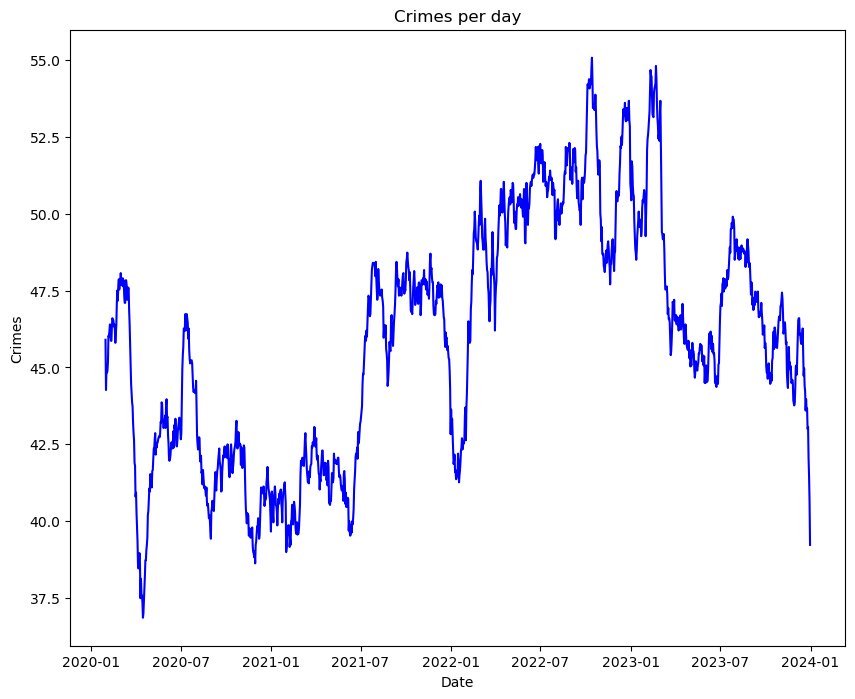

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

crimes_per_day = crime_df.groupby("DATE_OCCURRED").size().rolling(30).mean()
ax.plot(crimes_per_day.index, crimes_per_day, label="Crimes per day", color="blue")

ax.set_title("Crimes per day")
ax.set_xlabel("Date")
ax.set_ylabel("Crimes")

Text(0, 0.5, 'Crimes')

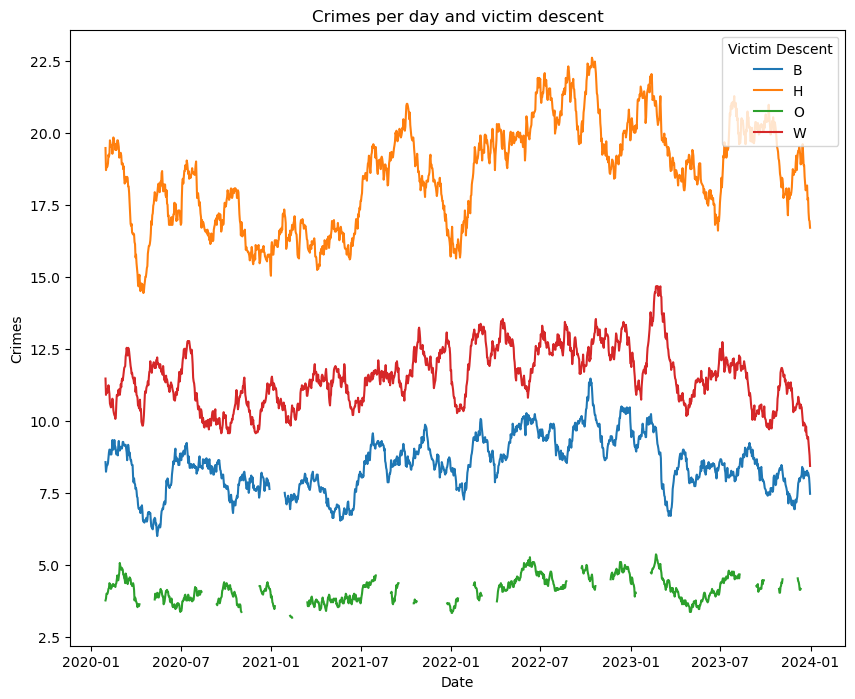

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

descents.plot(ax=ax, legend=False)

ax.legend(descents.columns, title="Victim Descent", loc="upper right")
ax.set_title("Crimes per day and victim descent")
ax.set_xlabel("Date")
ax.set_ylabel("Crimes")

### Visualize the Data

C:\Users\Saman\AppData\Local\Temp\ipykernel_464\1047128495.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=30, ha='right')
C:\Users\Saman\AppData\Local\Temp\ipykernel_464\1047128495.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,2].set_yticklabels(ax[0,2].get_yticklabels(), rotation=45, ha='right')


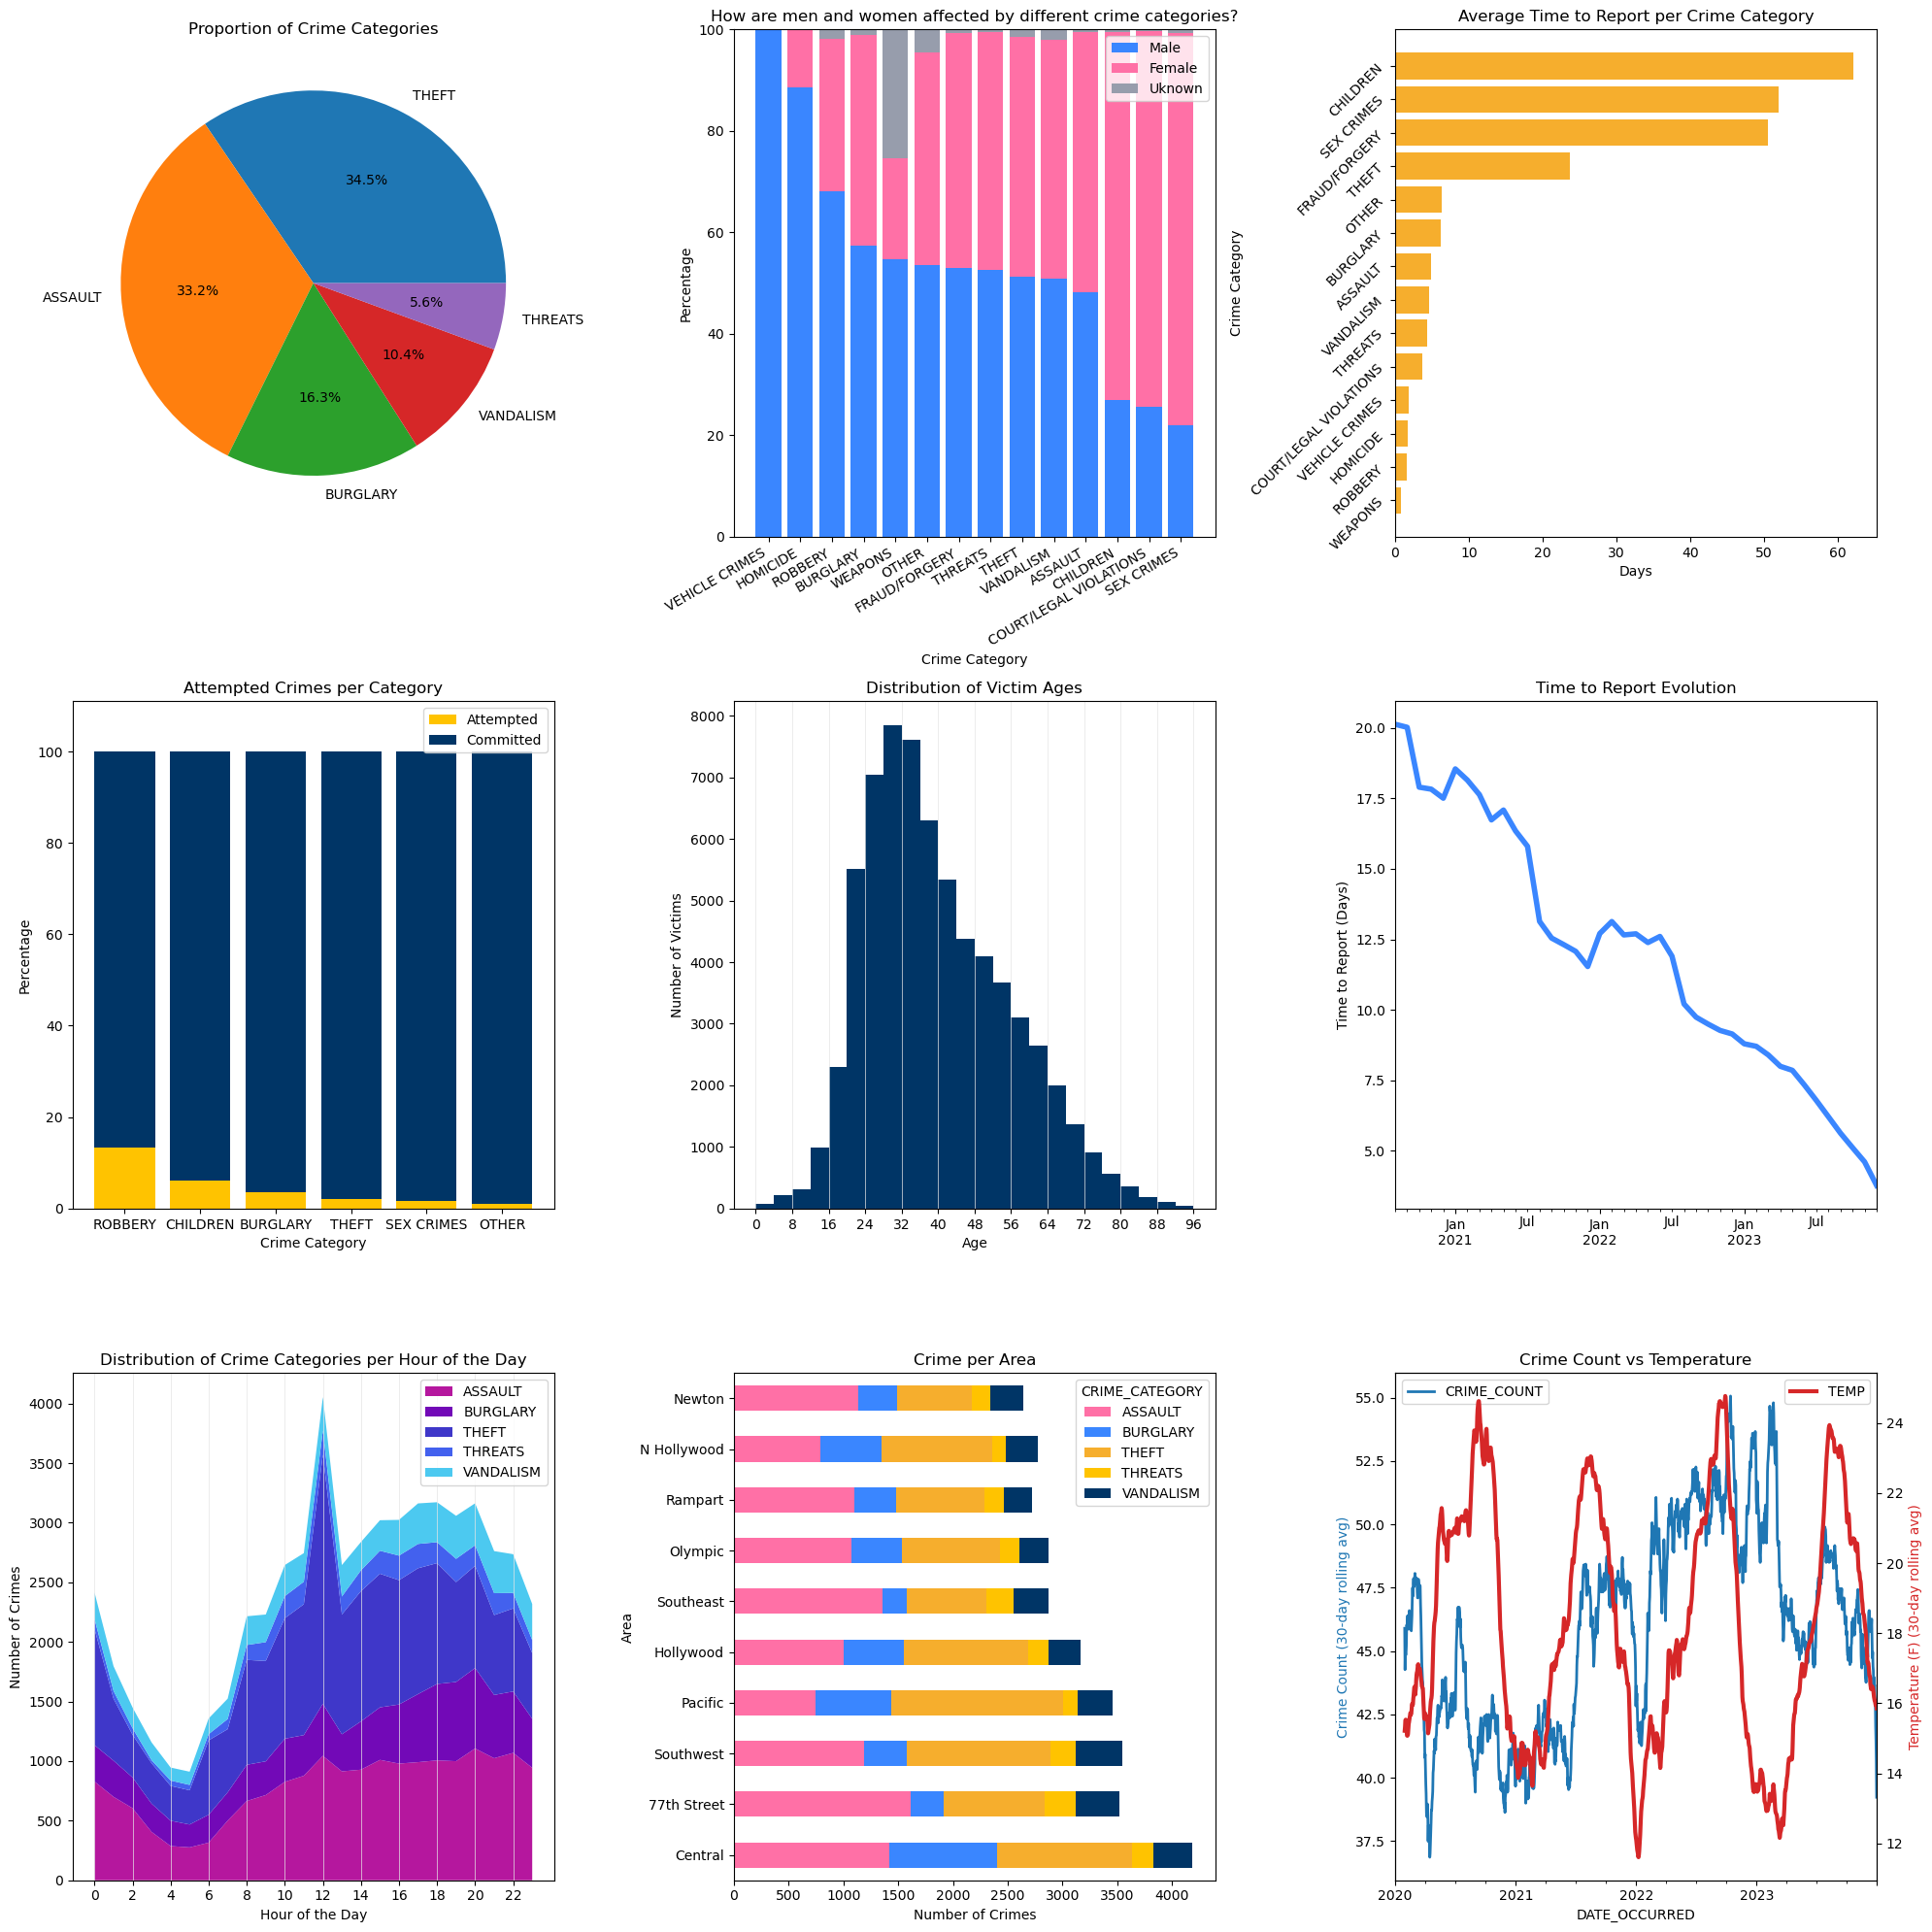

In [27]:

fig, ax = plt.subplots(3,3)
fig.set_size_inches(20, 20)

ax[0,0].set_title("Proportion of Crime Categories")
ax[0,0].pie(category_proportions, labels=category_proportions.index, autopct="%1.1f%%")

ax[0,1].set_title("How are men and women affected by different crime categories?")
ax[0,1].bar(sex_per_category.index, sex_per_category["M"], color="#3a86ff")
ax[0,1].bar(sex_per_category.index, sex_per_category["F"], bottom=sex_per_category["M"], color="#ff70a6")
ax[0,1].bar(sex_per_category.index, sex_per_category["X"], bottom=sex_per_category["F"]+sex_per_category["M"], color="#979dac")
ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=30, ha='right')
ax[0,1].margins(y=0.11)
ax[0,1].legend(["Male","Female","Uknown"],loc="upper right")
ax[0,1].set_ylabel("Percentage")
ax[0,1].set_xlabel("Crime Category")

ax[0,2].set_title("Average Time to Report per Crime Category")
ax[0,2].barh(category_avg_ttr.index, category_avg_ttr, color="#f6ae2d")
ax[0,2].set_xlabel("Days")
ax[0,2].set_ylabel("Crime Category")
ax[0,2].set_yticklabels(ax[0,2].get_yticklabels(), rotation=45, ha='right')

ax[1,0].set_title("Attempted Crimes per Category")
ax[1,0].bar(category_attempted.index, category_attempted["ATTEMPTED"], color="#ffc300")
ax[1,0].bar(category_attempted.index, category_attempted["COMMITTED"], bottom=category_attempted["ATTEMPTED"], color="#003566")
ax[1,0].set_xlabel("Crime Category")
ax[1,0].set_ylabel("Percentage")
ax[1,0].margins(y=0.11)
ax[1,0].legend(["Attempted","Committed"], loc="upper right")

ax[1,1].set_title("Distribution of Victim Ages")
ax[1,1].hist(x=crime_df["VICTIM_AGE"], bins=range(0,100,4), color="#003566")
ax[1,1].grid(True, axis="x", linewidth=.5, linestyle="-", color="#e5e5e5")
ax[1,1].set_xlabel("Age")
ax[1,1].set_ylabel("Number of Victims")
ax[1,1].set_xticks(np.arange(0,100,8))

ax[1,2].set_title("Time to Report Evolution")
ttr_evolution.plot(x="YEAR_MONTH", y="TIME_TO_REPORT", ax=ax[1,2], color="#3a86ff", ylabel="Time to Report (Days)", xlabel="", legend=False, linewidth=4)

ax[2,0].set_title("Distribution of Crime Categories per Hour of the Day")
ax[2,0].stackplot(hour_distribution.index, hour_distribution.T, labels=hour_distribution.columns, colors=["#b5179e", "#7209b7", "#3f37c9", "#4361ee", "#4cc9f0"])
ax[2,0].set_xlabel("Hour of the Day")
ax[2,0].set_xticks(np.arange(0,24,2))
ax[2,0].set_ylabel("Number of Crimes")
ax[2,0].legend(loc="upper right")
ax[2,0].grid(True, axis="x", linewidth=.5, linestyle="-", color="#e5e5e5")

ax[2,1].set_title("Crime per Area")
category_per_area.plot(kind="barh", stacked=True, ax=ax[2,1], color=["#ff70a6", "#3a86ff", "#f6ae2d", "#ffc300", "#003566"], ylabel="Area", xlabel="Number of Crimes", legend=True)

ax[2,2].set_title("Crime Count vs Temperature")
ax[2,2].set_xlabel("Date")
ax[2,2].set_ylabel("Crime Count (30-day rolling avg)", color="tab:blue")
ax2 = ax[2,2].twinx()
ax2.set_ylabel("Temperature (F) (30-day rolling avg)", color="tab:red")

crime_weather_joined.plot(y="CRIME_COUNT", x="DATE_OCCURRED", ax=ax[2,2], color="tab:blue", linewidth=2)
crime_weather_joined.plot(y="TEMP", x="DATE_OCCURRED", ax=ax2, color="tab:red", linewidth=3)


plt.tight_layout()
# plt.show()

### Geospatial K-Means Clustering

Cluster Centers:
 [[  34.20774315 -118.56572723]
 [  34.07128576 -118.32924787]
 [  34.01149671 -118.43363374]
 [  33.76670116 -118.28402428]
 [  34.20987427 -118.42379859]
 [  33.97480568 -118.28501929]
 [  34.05899352 -118.24578838]]


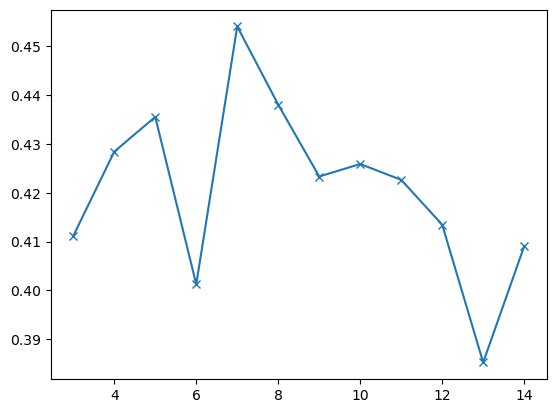

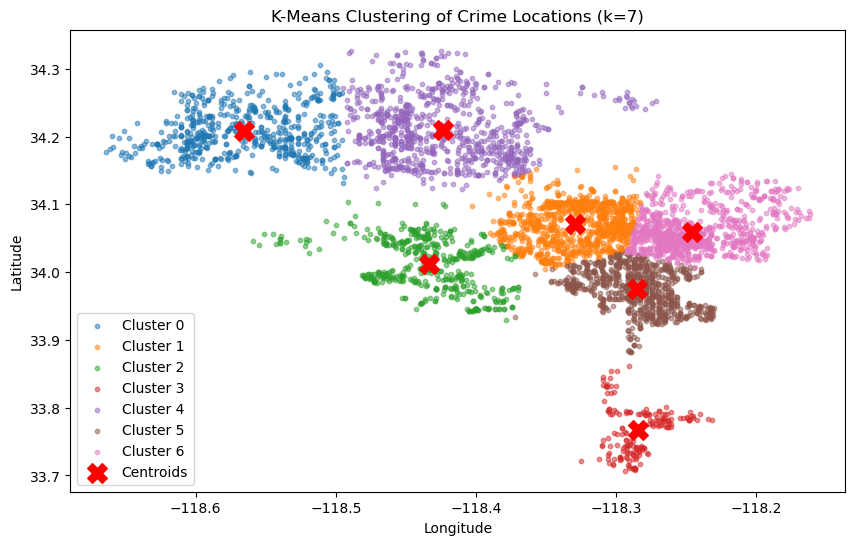

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

geo_data = crime_df[["LAT", "LON"]].sample(5000, random_state=40)

inertia = []
k_values = range(3, 15)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=40)
    kmeans.fit(geo_data)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(geo_data, kmeans.labels_)
    silhouette_scores.append(score)


plt.plot(k_values, silhouette_scores, marker='x')

optimal_k = silhouette_scores.index(max(silhouette_scores)) + 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
geo_data['Cluster'] = kmeans.fit_predict(geo_data)

# Show cluster centers
print("Cluster Centers:\n", kmeans.cluster_centers_)

plt.figure(figsize=(10, 6))

# Plot each cluster with different colors
for cluster_id in range(optimal_k):
    clustered_data = geo_data[geo_data['Cluster'] == cluster_id]
    plt.scatter(clustered_data['LON'], clustered_data['LAT'], s=10, alpha=0.5, label=f"Cluster {cluster_id}")

# Plot the cluster centroids
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='red', marker='X', s=200, label='Centroids')

plt.title(f"K-Means Clustering of Crime Locations (k={optimal_k})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


In [ ]:
import folium

# Center the map around the average location
map_center = [geo_data['LAT'].mean(), geo_data['LON'].mean()]
crime_map = folium.Map(location=map_center, zoom_start=10)

# Define colors for each cluster
colors = ['blue', 'green', 'orange', 'purple', 'darkred']

# Add crime locations to the maps
for _, row in geo_data.iterrows():
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=3,
        color=colors[int(row['Cluster'])],
        fill=True,
        fill_color=colors[int(row['Cluster'])],
        fill_opacity=0.2
    ).add_to(crime_map)

# Plot cluster centroids
for center in centers:
    folium.Marker(
        location=[center[0], center[1]],
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(crime_map)

# Save and display map
crime_map.save("crime_clusters_map.html")


### Random Forest Model

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
# Prepare the data
model_data = crime_df[["VICTIM_AGE", "VICTIM_SEX", "AREA_NAME", "HOUR", "CRIME_CODE"]].sample(n=1000, random_state=42)

def time_of_day(hour):
    if 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour < 24:
        return "Evening"
    else:
        return "Night"
    
model_data["TIME_OF_DAY"] = model_data["HOUR"].apply(time_of_day)

model_data = pd.get_dummies(model_data, columns=["VICTIM_SEX", "AREA_NAME", "TIME_OF_DAY"], drop_first=True)

label_encoder = LabelEncoder()
model_data["CRIME_CODE"] = label_encoder.fit_transform(model_data["CRIME_CODE"])

X = model_data.drop("CRIME_CODE", axis=1)
columns = X.columns

y = model_data["CRIME_CODE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

# Get unique classes in y_test
unique_labels = sorted(set(y_test))

# Convert these labels to their original string format
target_names = [str(label) for label in label_encoder.inverse_transform(unique_labels)]

# Generate a classification report
report = classification_report(y_test, y_pred, labels=unique_labels, target_names=target_names)
print(report)

scores = cross_val_score(best_model, X, y, cv=5, scoring='f1_weighted')
print("Average F1-Weighted Score from Cross-Validation:", scores.mean())

# Example input data
new_data = pd.DataFrame({
    'VICTIM_AGE': [25],
    'HOUR': [21],
    'VICTIM_SEX_F': [1],
    'AREA_NAME_Central': [1],
    'TIME_OF_DAY_Afternoon': [1]
})
new_data = new_data.reindex(columns=columns, fill_value=0)

# Predict crime type
predicted_crime_type = best_model.predict(new_data)
print("Predicted Crime Type:", label_encoder.inverse_transform(predicted_crime_type))

a:\miniconda3\envs\la_crime\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy: 0.11
              precision    recall  f1-score   support

         210       0.14      0.10      0.12        10
         220       0.00      0.00      0.00         5
         230       0.33      0.30      0.32        10
         236       0.00      0.00      0.00         3
         251       0.00      0.00      0.00         1
         310       0.08      0.11      0.09         9
         320       0.00      0.00      0.00         1
         330       0.16      0.27      0.20        15
         331       0.00      0.00      0.00         9
         341       0.00      0.00      0.00         3
         350       0.00      0.00      0.00         1
         354       0.27      0.15      0.20        26
         410       0.00      0.00      0.00         1
         420       0.00      0.00      0.00         5
         421       0.00      0.00      0.00         1
         440       0.00      0.00      0.00         9
         442       1.00      0.50      0.67         2
         450

a:\miniconda3\envs\la_crime\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
a:\miniconda3\envs\la_crime\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
a:\miniconda3\envs\la_crime\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
a:\miniconda3\envs\la_crime\Lib

Average F1-Weighted Score from Cross-Validation: 0.07427878597349287
Predicted Crime Type: [230]


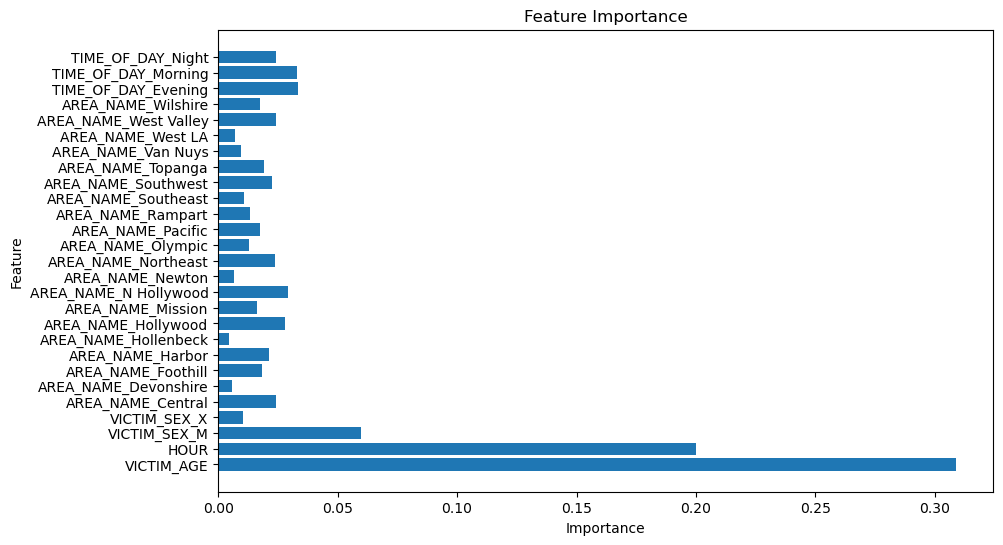

In [ ]:
importances = best_model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

